# General Formats:
 - Imports
 - Loading Data
 - Create features and target variable
 - Split Categorical and Numrical Features
 - Start the pipeline w/Encoding
 - Combine the Pipelines
 - Split into training and testing datasets
 - Train and predict model
 - Evaluate Model Accuracy
 - Optimize


In [ ]:
# Section 1 — Environment check, imports, and helper functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# sklearn imports
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder

In [2]:
import os
print(os.getcwd())

c:\Users\User\Desktop


In [3]:
train = pd.read_csv("Train.csv", low_memory=False)
valid = pd.read_csv("Valid.csv", low_memory=False)

## Data Preprocessing - issues to check
1. Missing Values + No Data notations - standartization
2. Incorrect Datatypes

### <u> Functions </u>

In [4]:
#Unify missing value representations funciton

def standardize_missing_values(df, missing_strings):
    obj_cols = df.select_dtypes(include=["object"]).columns
    for col in obj_cols:
        df[col] = df[col].replace(missing_strings, np.nan)  
    return df

  


In [5]:
#This is just a colorful way to see the data types with the column names - only with colors :)
def head_with_dtypes(df, n=5):
    df_temp = df.head(n).copy()
    df_temp.columns = [
        f"{col}<br><span style='color:pink'>({dtype})</span>"
        for col, dtype in zip(df.columns, df.dtypes)
    ]
    return df_temp.style.set_table_styles(
        [{"selector": "th", "props": [("text-align", "center")]}]
    )


In [6]:
# Decompose date column into several features and drop the original date column

def add_date_parts(df: pd.DataFrame, date_col: str = "saledate"):
    if date_col in df.columns:
        if not np.issubdtype(df[date_col].dtype, np.datetime64):
            df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
        df["saleYear"] = df[date_col].dt.year
        df["saleMonth"] = df[date_col].dt.month
        df["saleDay"] = df[date_col].dt.day
        df["saleDayofweek"] = df[date_col].dt.dayofweek
        df["saleDayofyear"] = df[date_col].dt.dayofyear
        df["saleQuarter"] = df[date_col].dt.quarter
        df.drop(columns=[date_col], inplace=True)

In [7]:
def sorted_datetime_conversion(df: pd.DataFrame, date_col: str = "saledate"):
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df.sort_values(by=["saledate"], inplace=True, ascending=True)
    return df

In [8]:
def drop_unhelpful_columns(df, target="SalePrice", missing_threshold=95):
    drop_cols = ["SalesID", "MachineID", "ModelID"]
    
    # drop high-missing columns
    missing_info = (df.isnull().sum() / len(df)) * 100
    drop_cols += missing_info[missing_info > missing_threshold].index.tolist()
    
    # drop obvious duplicates
    dupes = ["ProductGroupDesc", "Enclosure_Type"]  # keep ProductGroup & Enclosure
    drop_cols += [c for c in dupes if c in df.columns]
    
    # don't drop the target!
    drop_cols = [c for c in drop_cols if c != target]
    
    print("Dropping:", drop_cols)
    return df.drop(columns=drop_cols, errors="ignore")


# EDA :

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   401125 non-null  int64  
 1   SalePrice                 401125 non-null  int64  
 2   MachineID                 401125 non-null  int64  
 3   ModelID                   401125 non-null  int64  
 4   datasource                401125 non-null  int64  
 5   auctioneerID              380989 non-null  float64
 6   YearMade                  401125 non-null  int64  
 7   MachineHoursCurrentMeter  142765 non-null  float64
 8   UsageBand                 69639 non-null   object 
 9   saledate                  401125 non-null  object 
 10  fiModelDesc               401125 non-null  object 
 11  fiBaseModel               401125 non-null  object 
 12  fiSecondaryDesc           263934 non-null  object 
 13  fiModelSeries             56908 non-null   o

In [10]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11573 entries, 0 to 11572
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SalesID                   11573 non-null  int64  
 1   MachineID                 11573 non-null  int64  
 2   ModelID                   11573 non-null  int64  
 3   datasource                11573 non-null  int64  
 4   auctioneerID              11573 non-null  int64  
 5   YearMade                  11573 non-null  int64  
 6   MachineHoursCurrentMeter  4739 non-null   float64
 7   UsageBand                 4031 non-null   object 
 8   saledate                  11573 non-null  object 
 9   fiModelDesc               11573 non-null  object 
 10  fiBaseModel               11573 non-null  object 
 11  fiSecondaryDesc           8037 non-null   object 
 12  fiModelSeries             1759 non-null   object 
 13  fiModelDescriptor         2897 non-null   object 
 14  Produc

In [11]:
def check_column_consistency(df1, df2, name1="df1", name2="df2"):
    """
    Check if two DataFrames have the same columns and dtypes.
    Prints differences in column names and type mismatches.
    """
    cols1 = set(df1.columns)
    cols2 = set(df2.columns)

    only_in_1 = cols1 - cols2
    only_in_2 = cols2 - cols1

    if only_in_1:
        print(f"Columns only in {name1}: {only_in_1}")
    if only_in_2:
        print(f"Columns only in {name2}: {only_in_2}")

    if not only_in_1 and not only_in_2:
        print("Both have the same column names")

    # Now check dtypes for matching columns
    mismatched = []
    for col in df1.columns:
        if col in df2.columns:
            if df1[col].dtype != df2[col].dtype:
                mismatched.append((col, df1[col].dtype, df2[col].dtype))

    if mismatched:
        print("\n Dtype mismatches found:")
        for col, t1, t2 in mismatched:
            print(f"- {col}: {name1}={t1}, {name2}={t2}")
    else:
        print("All matching columns have the same dtype")
    

In [12]:
check_column_consistency(train, valid, "train", "valid")

Columns only in train: {'SalePrice'}

 Dtype mismatches found:
- auctioneerID: train=float64, valid=int64


In [13]:
head_with_dtypes(train, 3)
# We need to fix the following columns:
# saledate - convert to datetime and decompose

,SalesID(int64),SalePrice(int64),MachineID(int64),ModelID(int64),datasource(int64),auctioneerID(float64),YearMade(int64),MachineHoursCurrentMeter(float64),UsageBand(object),saledate(object),fiModelDesc(object),fiBaseModel(object),fiSecondaryDesc(object),fiModelSeries(object),fiModelDescriptor(object),ProductSize(object),fiProductClassDesc(object),state(object),ProductGroup(object),ProductGroupDesc(object),Drive_System(object),Enclosure(object),Forks(object),Pad_Type(object),Ride_Control(object),Stick(object),Transmission(object),Turbocharged(object),Blade_Extension(object),Blade_Width(object),Enclosure_Type(object),Engine_Horsepower(object),Hydraulics(object),Pushblock(object),Ripper(object),Scarifier(object),Tip_Control(object),Tire_Size(object),Coupler(object),Coupler_System(object),Grouser_Tracks(object),Hydraulics_Flow(object),Track_Type(object),Undercarriage_Pad_Width(object),Stick_Length(object),Thumb(object),Pattern_Changer(object),Grouser_Type(object),Backhoe_Mounting(object),Blade_Type(object),Travel_Controls(object),Differential_Type(object),Steering_Controls(object)
0,1139246,66000,999089,3157,121,3.000000,2004,68.000000,Low,11/16/2006 0:00,521D,521,D,nan,nan,nan,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,nan,EROPS w AC,None or Unspecified,nan,None or Unspecified,nan,nan,nan,nan,nan,nan,nan,2 Valve,nan,nan,nan,nan,None or Unspecified,None or Unspecified,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,Standard,Conventional
1,1139248,57000,117657,77,121,3.000000,1996,4640.000000,Low,3/26/2004 0:00,950FII,950,F,II,nan,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,nan,EROPS w AC,None or Unspecified,nan,None or Unspecified,nan,nan,nan,nan,nan,nan,nan,2 Valve,nan,nan,nan,nan,23.5,None or Unspecified,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,Standard,Conventional
2,1139249,10000,434808,7009,121,3.000000,2001,2838.000000,High,2/26/2004 0:00,226,226,nan,nan,nan,nan,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,nan,OROPS,None or Unspecified,nan,nan,nan,nan,nan,nan,nan,nan,nan,Auxiliary,nan,nan,nan,nan,nan,None or Unspecified,None or Unspecified,None or Unspecified,Standard,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [14]:
head_with_dtypes(valid, 3)

,SalesID(int64),MachineID(int64),ModelID(int64),datasource(int64),auctioneerID(int64),YearMade(int64),MachineHoursCurrentMeter(float64),UsageBand(object),saledate(object),fiModelDesc(object),fiBaseModel(object),fiSecondaryDesc(object),fiModelSeries(object),fiModelDescriptor(object),ProductSize(object),fiProductClassDesc(object),state(object),ProductGroup(object),ProductGroupDesc(object),Drive_System(object),Enclosure(object),Forks(object),Pad_Type(object),Ride_Control(object),Stick(object),Transmission(object),Turbocharged(object),Blade_Extension(object),Blade_Width(object),Enclosure_Type(object),Engine_Horsepower(object),Hydraulics(object),Pushblock(object),Ripper(object),Scarifier(object),Tip_Control(object),Tire_Size(object),Coupler(object),Coupler_System(object),Grouser_Tracks(object),Hydraulics_Flow(object),Track_Type(object),Undercarriage_Pad_Width(object),Stick_Length(object),Thumb(object),Pattern_Changer(object),Grouser_Type(object),Backhoe_Mounting(object),Blade_Type(object),Travel_Controls(object),Differential_Type(object),Steering_Controls(object)
0,1222837,902859,1376,121,3,1000,0.000000,nan,1/5/2012 0:00,375L,375,nan,nan,L,Large / Medium,"Hydraulic Excavator, Track - 66.0 to 90.0 Metric Tons",Kentucky,TEX,Track Excavators,nan,EROPS,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,Standard,nan,nan,nan,nan,nan,None or Unspecified,nan,nan,nan,Steel,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,nan,nan,nan,nan,nan
1,1222839,1048320,36526,121,3,2006,4412.000000,Medium,1/5/2012 0:00,TX300LC2,TX300,LC,2,nan,Large / Medium,"Hydraulic Excavator, Track - 28.0 to 33.0 Metric Tons",Connecticut,TEX,Track Excavators,nan,EROPS w AC,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,Auxiliary,nan,nan,nan,nan,nan,Hydraulic,nan,nan,nan,Steel,None or Unspecified,"12' 4""",None or Unspecified,Yes,Double,nan,nan,nan,nan,nan
2,1222841,999308,4587,121,3,2000,10127.000000,Medium,1/5/2012 0:00,270LC,270,nan,nan,LC,Large / Medium,"Hydraulic Excavator, Track - 24.0 to 28.0 Metric Tons",Connecticut,TEX,Track Excavators,nan,EROPS w AC,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,Auxiliary,nan,nan,nan,nan,nan,None or Unspecified,nan,nan,nan,Steel,None or Unspecified,"12' 4""",None or Unspecified,None or Unspecified,Double,nan,nan,nan,nan,nan


### Train & Valid Tables - Dtypes corrections + feature engineering:
- saledate - convert to datetime and decompose
- yearmade - irrelevant values (1800, 1000, 9999) - replace with NaN

In [15]:
sorted_datetime_conversion(train, "saledate")
sorted_datetime_conversion(valid, "saledate")

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
4550,4449186,2318824,26964,173,99,1996,0.0,NaN,2012-01-01,D65E12,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,NaN,NaN
4951,6258613,1810917,13260,149,99,2000,24.0,Low,2012-01-04,590SUPER LII,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7893,6282680,1543404,1830,149,99,2004,4373.0,Medium,2012-01-04,120C,...,24 inch,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
7901,6282759,1863077,11390,149,99,2006,3467.0,Medium,2012-01-04,160CLC,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
4,1222845,1032841,4701,121,3,2002,8150.0,Medium,2012-01-04,544H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11351,6324811,1919104,19330,149,99,2004,NaN,NaN,2012-04-28,2064,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8771,6286551,1866718,4605,149,99,2006,NaN,NaN,2012-04-28,310G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8776,6286556,1793587,4605,149,99,2006,NaN,NaN,2012-04-28,310G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4652,6256957,1860454,6868,149,99,1000,NaN,NaN,2012-04-28,9050,...,None or Unspecified,None or Unspecified,Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN


In [16]:
valid.saledate.head(5), train.saledate.tail(5)

(4550   2012-01-01
 4951   2012-01-04
 7893   2012-01-04
 7901   2012-01-04
 4      2012-01-04
 Name: saledate, dtype: datetime64[ns],
 393123   2011-12-30
 397987   2011-12-30
 392664   2011-12-30
 400458   2011-12-30
 400217   2011-12-30
 Name: saledate, dtype: datetime64[ns])

In [17]:
add_date_parts(train, "saledate")
add_date_parts(valid, "saledate")

In [18]:
# invalid dates in yearmade column - replace with NaN

for df in [train, valid]:
    add_date_parts(df, "saledate")
    # Fix invalid YearMade like 1000
    if "YearMade" in df.columns:
        df.loc[df["YearMade"] < 1900, "YearMade"] = np.nan

# Handle Missing Data / None notations:

In [19]:
train.isnull().sum().sort_values(ascending=False)

Blade_Width                 375906
Blade_Extension             375906
Engine_Horsepower           375906
Enclosure_Type              375906
Tip_Control                 375906
Pushblock                   375906
Scarifier                   375895
Hydraulics_Flow             357763
Grouser_Tracks              357763
Coupler_System              357667
fiModelSeries               344217
Steering_Controls           331756
Differential_Type           331714
UsageBand                   331486
fiModelDescriptor           329206
Backhoe_Mounting            322453
Turbocharged                321991
Pad_Type                    321991
Stick                       321991
Blade_Type                  321292
Travel_Controls             321291
Tire_Size                   306407
Grouser_Type                301972
Track_Type                  301972
Pattern_Changer             301907
Stick_Length                301907
Thumb                       301837
Undercarriage_Pad_Width     301253
Ripper              

In [20]:
valid.isnull().sum().sort_values(ascending=False)

Blade_Extension             10809
Engine_Horsepower           10809
Tip_Control                 10809
Scarifier                   10809
Pushblock                   10809
Blade_Width                 10809
Enclosure_Type              10809
Hydraulics_Flow             10060
Grouser_Tracks              10060
Coupler_System              10057
fiModelSeries                9814
Stick                        9611
Pad_Type                     9611
Turbocharged                 9611
Backhoe_Mounting             9533
Blade_Type                   9531
Travel_Controls              9530
Steering_Controls            9420
Differential_Type            9420
Drive_System                 8847
Ripper                       8765
fiModelDescriptor            8676
Tire_Size                    8653
Grouser_Type                 8533
Track_Type                   8533
Pattern_Changer              8530
Stick_Length                 8530
Undercarriage_Pad_Width      8529
Thumb                        8529
UsageBand     

In [21]:
missing_strings =["None", "none", "NONE","None or Unspecified","Unspecified","nan", "NaN","<NA>","NA","N/A","n/a","Na"]

standardize_missing_values(train,missing_strings)
standardize_missing_values(valid,missing_strings)

C:\Users\User\AppData\Local\Temp\ipykernel_7860\1305001617.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(missing_strings, np.nan)


,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear,saleQuarter
4550,4449186,2318824,26964,173,99,1996.0,0.0,NaN,D65E12,D65,...,NaN,NaN,NaN,NaN,2012,1,1,6,1,1
4951,6258613,1810917,13260,149,99,2000.0,24.0,Low,590SUPER LII,590,...,NaN,NaN,NaN,NaN,2012,1,4,2,4,1
7893,6282680,1543404,1830,149,99,2004.0,4373.0,Medium,120C,120,...,NaN,NaN,NaN,NaN,2012,1,4,2,4,1
7901,6282759,1863077,11390,149,99,2006.0,3467.0,Medium,160CLC,160,...,NaN,NaN,NaN,NaN,2012,1,4,2,4,1
4,1222845,1032841,4701,121,3,2002.0,8150.0,Medium,544H,544,...,NaN,NaN,Standard,Conventional,2012,1,4,2,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11351,6324811,1919104,19330,149,99,2004.0,NaN,NaN,2064,2064,...,NaN,NaN,NaN,NaN,2012,4,28,5,119,2
8771,6286551,1866718,4605,149,99,2006.0,NaN,NaN,310G,310,...,NaN,NaN,NaN,NaN,2012,4,28,5,119,2
8776,6286556,1793587,4605,149,99,2006.0,NaN,NaN,310G,310,...,NaN,NaN,NaN,NaN,2012,4,28,5,119,2
4652,6256957,1860454,6868,149,99,NaN,NaN,NaN,9050,9050,...,NaN,NaN,NaN,NaN,2012,4,28,5,119,2


# 

## Feature Engineering:

In [22]:
train["machine_age"] = train["saleYear"] - train["YearMade"]
valid["machine_age"] = valid["saleYear"] - valid["YearMade"]

for df in [train, valid]:
    df["log_hours"] = np.log1p(df["MachineHoursCurrentMeter"])

sale_counts = train.groupby("MachineID")["SalePrice"].count()
train["machine_sale_count"] = train["MachineID"].map(sale_counts)

valid["machine_sale_count"] = valid["MachineID"].map(sale_counts)



# Model Preprations:

Text(0.5, 0, 'Sale Year')

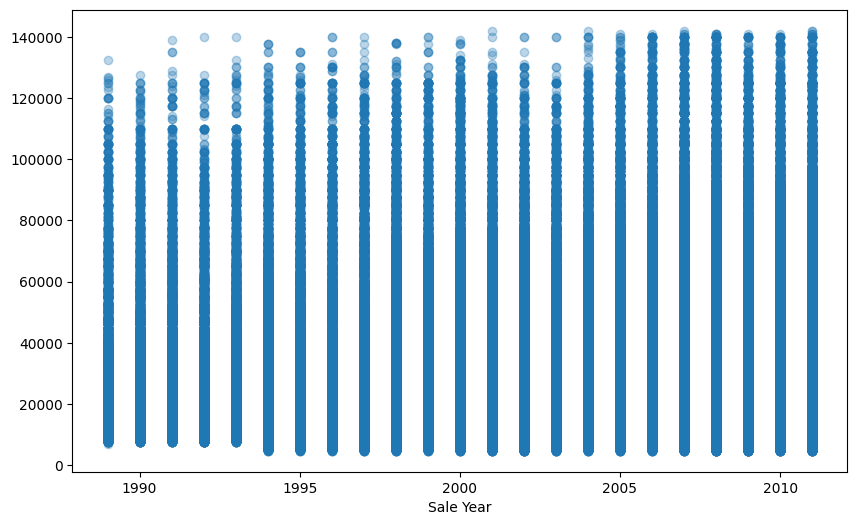

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(train["saleYear"], train["SalePrice"], alpha=0.3)
plt.xlabel("Sale Year")

In [24]:
train = drop_unhelpful_columns(train)
valid = drop_unhelpful_columns(valid) 


Dropping: ['SalesID', 'MachineID', 'ModelID', 'Forks', 'Pad_Type', 'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Pushblock', 'Scarifier', 'Tip_Control', 'Coupler_System', 'Grouser_Tracks', 'Thumb', 'Pattern_Changer', 'Backhoe_Mounting', 'Travel_Controls', 'ProductGroupDesc', 'Enclosure_Type']
Dropping: ['SalesID', 'MachineID', 'ModelID', 'Pad_Type', 'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type', 'Pushblock', 'Scarifier', 'Tip_Control', 'Coupler_System', 'Grouser_Tracks', 'Undercarriage_Pad_Width', 'Stick_Length', 'Pattern_Changer', 'Backhoe_Mounting', 'Travel_Controls', 'ProductGroupDesc', 'Enclosure_Type']


In [25]:
train.head(5)

,SalePrice,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,...,Steering_Controls,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear,saleQuarter,machine_age,log_hours,machine_sale_count
205615,9500,132,18.0,1974.0,NaN,NaN,TD20,TD20,NaN,NaN,...,NaN,1989,1,17,1,17,1,15.0,NaN,1
92803,24000,132,99.0,1986.0,NaN,NaN,416,416,NaN,NaN,...,NaN,1989,1,31,1,31,1,3.0,NaN,2
98346,35000,132,99.0,1975.0,NaN,NaN,12G,12,G,NaN,...,NaN,1989,1,31,1,31,1,14.0,NaN,2
169297,19000,132,99.0,1978.0,NaN,NaN,644,644,NaN,NaN,...,Conventional,1989,1,31,1,31,1,11.0,NaN,1
274835,14000,132,99.0,1980.0,NaN,NaN,A66,A66,NaN,NaN,...,Conventional,1989,1,31,1,31,1,9.0,NaN,1


In [26]:
# Train on sales before 2010
train_df = train[train["saleYear"] < 2011].copy()
test_df = train[train["saleYear"] >= 2011].copy()

#train set X y definition :
X_train = train_df.drop(columns=["SalePrice"])
y_train = train_df["SalePrice"].astype(float)

#test set X y definition :
X_test = test_df.drop(columns=["SalePrice"])
y_test = test_df["SalePrice"].astype(float)

In [27]:
# feature lists from X_train
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# preprocessing: impute only for nums; impute + ordinal-encode cats
num_tr = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

cat_tr = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent", fill_value="Unknown")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

pre = ColumnTransformer([
    ("num", num_tr, num_cols),
    ("cat", cat_tr, cat_cols),
])

rf = Pipeline([
    ("preprocessor", pre),
    ("regressor", RandomForestRegressor(
        n_estimators=100,            # need to optimize
        max_depth=25,               # optimize?
        max_features="sqrt",
        n_jobs=-1,
        random_state=42
    ))
])

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2_score = r2_score(y_test, y_pred)
print(f"R2 Score: {r2_score:.2f}")
print(f"Validation RMSE: {rmse:.2f}")


R2 Score: 0.84
Validation RMSE: 10086.07



Top 20 features by importance:
                    feature  importance
10         num__machine_age    0.128240
20  cat__fiProductClassDesc    0.099742
24           cat__Enclosure    0.091655
14         cat__fiModelDesc    0.084375
16     cat__fiSecondaryDesc    0.083545
2             num__YearMade    0.077176
15         cat__fiBaseModel    0.066885
19         cat__ProductSize    0.066338
22        cat__ProductGroup    0.059153
4             num__saleYear    0.032532
29          cat__Hydraulics    0.020725
31           cat__Tire_Size    0.015790
18   cat__fiModelDescriptor    0.015316
38          cat__Blade_Type    0.015294
23        cat__Drive_System    0.015036
8        num__saleDayofyear    0.014101
6              num__saleDay    0.010935
34          cat__Track_Type    0.010651
21               cat__state    0.010651
5            num__saleMonth    0.008030


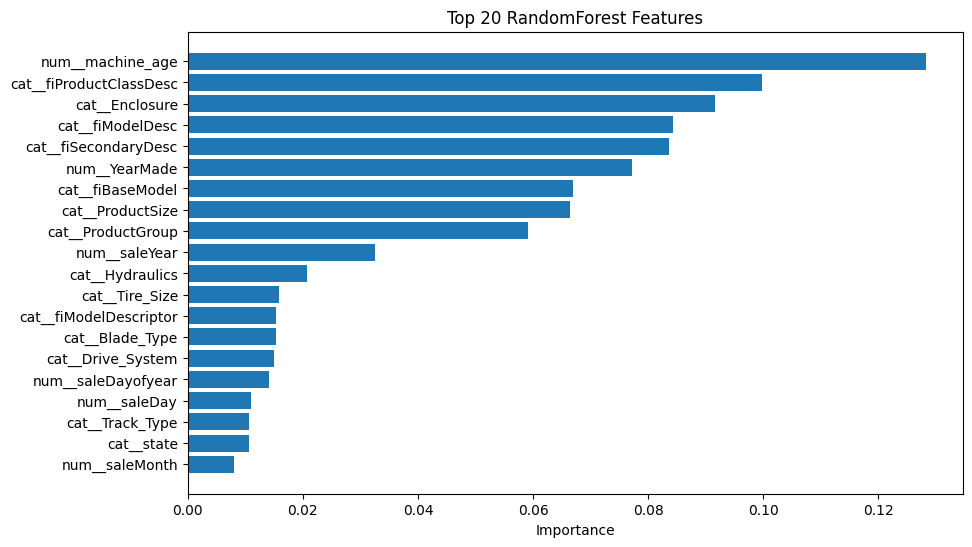

In [28]:

# Access trained RF from the pipeline
rf_model = rf.named_steps["regressor"]

# Get importances
importances = rf_model.feature_importances_

# Get feature names after preprocessing
feature_names = rf.named_steps["preprocessor"].get_feature_names_out()

# Put in a DataFrame for easy viewing

feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

print("\nTop 20 features by importance:")
print(feat_imp.head(20))

# Optional: plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.barh(feat_imp.head(20)["feature"][::-1], feat_imp.head(20)["importance"][::-1])
plt.xlabel("Importance")
plt.title("Top 20 RandomForest Features")
plt.show()

This long tail probabbly makes RMSE worse.. we need to check if to remove some with filter or try some other trick

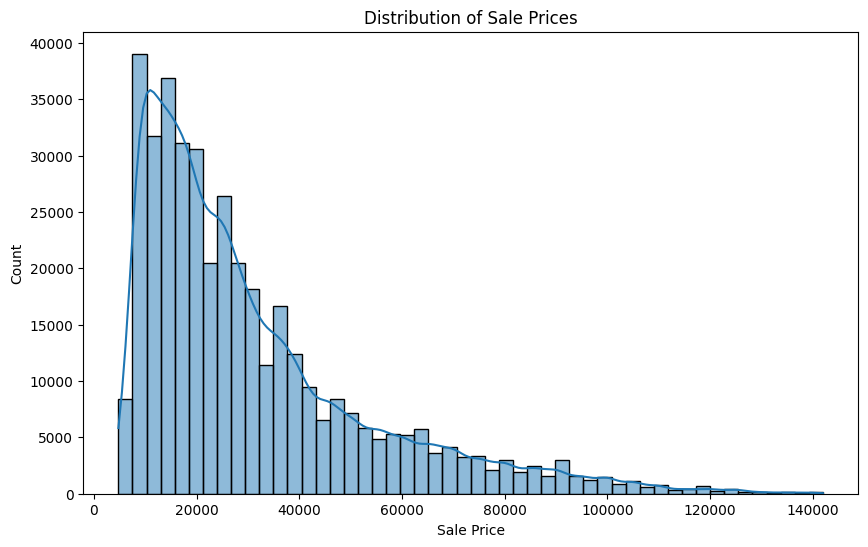

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(train["SalePrice"], bins=50, kde=True)
plt.xlabel("Sale Price")
plt.title("Distribution of Sale Prices")
plt.show()


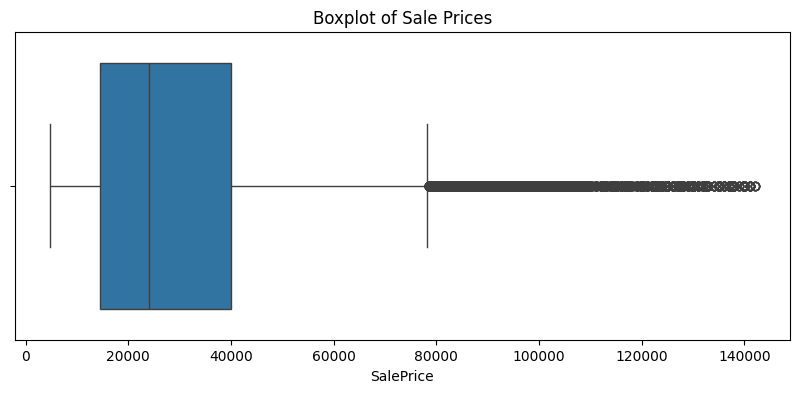

In [31]:
plt.figure(figsize=(10,4))
sns.boxplot(x=train["SalePrice"])
plt.title("Boxplot of Sale Prices")
plt.show()
